# POM ACO Network Evaluation and Optimization

Our project focuses on analyzing the POM ACO's provider networks across Michigan, examining the composition and performance of these networks over time. Through this analysis, we aim to uncover insights that can guide strategic decisions to optimize the network, ultimately improving performance against Medicare's mandated metrics.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

## EDA

In [2]:
df1 = pd.read_excel('./dataset/SOI_dataset.xlsx',sheet_name='TIN_Q1-5_TIN_Info')
df2 = pd.read_excel('./dataset/SOI_dataset.xlsx',sheet_name='TIN_Q7,8-Total_Cost_EnrollType')
df3 = pd.read_excel('./dataset/SOI_dataset.xlsx',sheet_name='TIN_Q9_TotalCost_By_Categories')
df4 = pd.read_excel('./dataset/SOI_dataset.xlsx',sheet_name='TIN_Q10-13_Event_Rate')
df5 = pd.read_excel('./dataset/SOI_dataset.xlsx',sheet_name='TIN_VISIT_Q8-14')

#### TIN_Q1-5_TIN_Info

In [3]:
df1.head(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE,BENE_CNT,AVR_RISK_SCORE
0,2019,OWTS,230982,ESRD,<11,4.244
1,2023,SDRU,636998,Disabled,<11,3.635
2,2023,OWTS,254468,Aged-Dual,<11,3.535
3,2022,OWTS,659770,ESRD,<11,3.239
4,2020,NTVP,592226,ESRD,<11,3.140


In [4]:
df1.size

6810

In [5]:
df1.isnull().sum()

PERFORMANCE_YEAR     0
QRO                  0
TIN_CCN              0
ENROLLMENT_TYPE      0
BENE_CNT             0
AVR_RISK_SCORE      22
dtype: int64

In [6]:
df1 = df1.fillna(0)

In [7]:
df1.QRO.unique()

array(['OWTS', 'SDRU', 'NTVP', 'MKLO', 'MTIP', 'UPLN'], dtype=object)

In [8]:
average_risk_by_qro = df1.groupby('QRO')['AVR_RISK_SCORE'].mean().reset_index()
average_risk_by_qro.sort_values('AVR_RISK_SCORE',ascending=False,inplace=True)
average_risk_by_qro

,QRO,AVR_RISK_SCORE
5,UPLN,1.194833
0,MKLO,1.182500
3,OWTS,1.010912
4,SDRU,0.898075
2,NTVP,0.896876
1,MTIP,0.760374


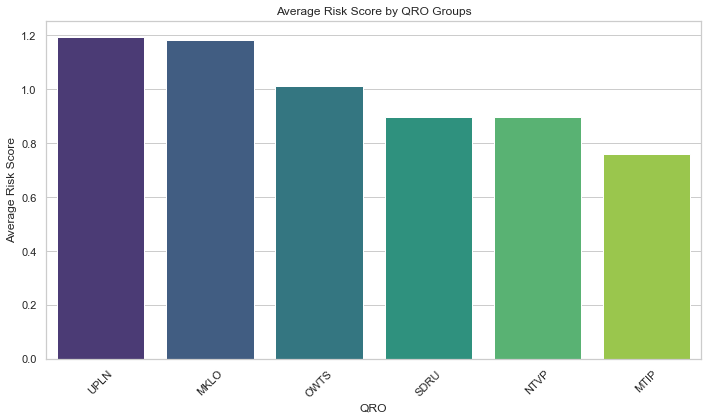

In [9]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.barplot(x='QRO',y='AVR_RISK_SCORE',data=average_risk_by_qro,palette='viridis')
plt.xlabel('QRO')
plt.ylabel('Average Risk Score')
plt.title('Average Risk Score by QRO Groups')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

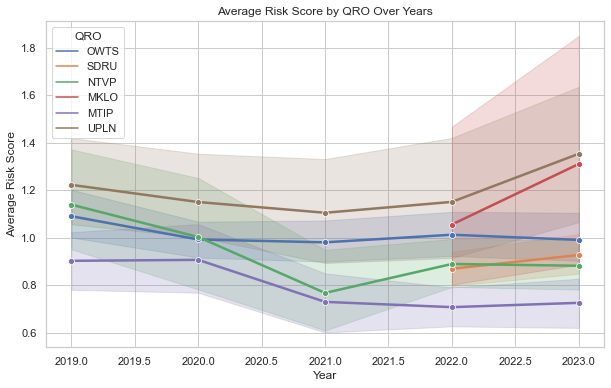

In [10]:
plt.figure(figsize=(10,6))
sns.lineplot(x='PERFORMANCE_YEAR',y='AVR_RISK_SCORE',data=df1,hue='QRO',marker='o',linewidth=2.5)
plt.title('Average Risk Score by QRO Over Years')
plt.xlabel('Year')
plt.ylabel('Average Risk Score')
plt.legend(title='QRO',loc='upper left')
plt.show()

In [11]:
df1[df1.QRO == 'UPLN']['ENROLLMENT_TYPE'].value_counts()

Disabled     5
Aged-Dual    5
Aged         5
ESRD         5
Unknown      4
Name: ENROLLMENT_TYPE, dtype: int64

UPLN receives more medically complex patients

#### TIN_Q7,8-Total_Cost_EnrollType

In [12]:
df2[df2.QRO == 'UPLN']

,PERFORMANCE_YEAR,QRO,TIN_CCN,TOTAL_SPEND,AGED_TOTAL_SPEND,DISABLED_TOTAL_SPEND,ESRD_TOTAL_ESRD,AGED_DUAL_TOTAL_SPEND
36,2019,UPLN,430950,2.399395e+08,1.629968e+08,41620297.54,18547627.79,16774793.22
78,2020,UPLN,430950,2.766308e+08,1.872492e+08,49279710.30,21949611.05,17201389.23
150,2021,UPLN,430950,3.111588e+08,2.151866e+08,54208480.34,19303294.13,19881386.70
262,2022,UPLN,430950,3.066105e+08,2.252036e+08,48224036.37,14761520.83,17764948.79
374,2023,UPLN,430950,2.772460e+08,2.112942e+08,37610732.92,12439351.48,14913897.84


In [13]:
df2.isnull().sum()

PERFORMANCE_YEAR           0
QRO                        0
TIN_CCN                    0
TOTAL_SPEND                0
AGED_TOTAL_SPEND          23
DISABLED_TOTAL_SPEND      48
ESRD_TOTAL_ESRD          230
AGED_DUAL_TOTAL_SPEND    103
dtype: int64

In [14]:
df2=df2.fillna(0)

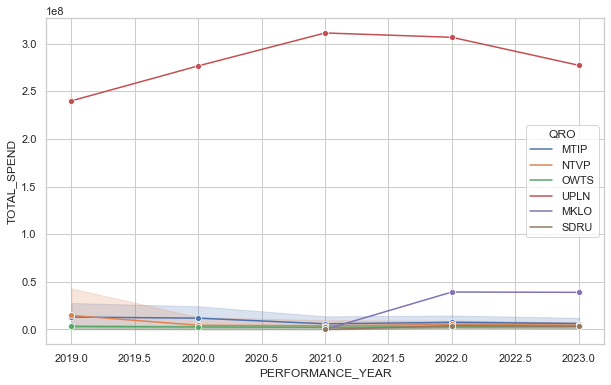

In [15]:
plt.figure(figsize=(10,6))
sns.lineplot(x='PERFORMANCE_YEAR',y='TOTAL_SPEND',data=df2,hue='QRO',marker='o')
plt.show()

In [16]:
df2_melted = df2.melt(id_vars=['PERFORMANCE_YEAR','QRO','TIN_CCN'],
                      value_vars=['AGED_TOTAL_SPEND', 'DISABLED_TOTAL_SPEND', 'ESRD_TOTAL_ESRD','AGED_DUAL_TOTAL_SPEND'],
                      var_name='SPEND_TYPE',
                      value_name='TOTAL_SPEND')
df2_melted

<ipython-input-16-6f9dcdd2bbc6>:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df2_melted = df2.melt(id_vars=['PERFORMANCE_YEAR','QRO','TIN_CCN'],


,PERFORMANCE_YEAR,QRO,TIN_CCN,SPEND_TYPE,TOTAL_SPEND
0,2019,MTIP,122406,AGED_TOTAL_SPEND,1755.58
1,2019,MTIP,679036,AGED_TOTAL_SPEND,122.30
2,2019,MTIP,344888,AGED_TOTAL_SPEND,0.00
3,2019,MTIP,125904,AGED_TOTAL_SPEND,165138.70
4,2019,MTIP,183834,AGED_TOTAL_SPEND,36549230.25
...,...,...,...,...,...
1495,2023,SDRU,877376,AGED_DUAL_TOTAL_SPEND,132900.31
1496,2023,SDRU,556858,AGED_DUAL_TOTAL_SPEND,173373.23
1497,2023,SDRU,676890,AGED_DUAL_TOTAL_SPEND,241529.24
1498,2023,SDRU,680049,AGED_DUAL_TOTAL_SPEND,1885.46


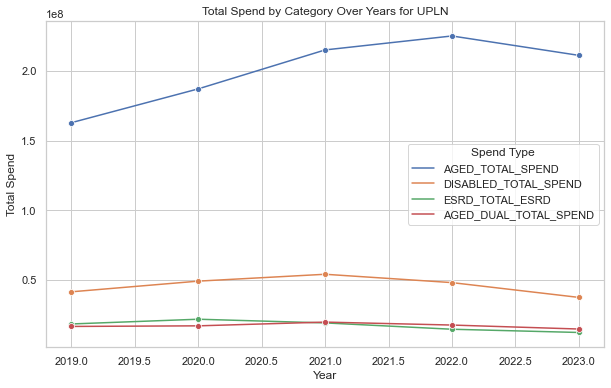

In [17]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df2_melted[df2_melted.QRO=='UPLN'],x='PERFORMANCE_YEAR',y='TOTAL_SPEND',hue='SPEND_TYPE',marker = 'o')
plt.title('Total Spend by Category Over Years for UPLN')
plt.xlabel('Year')
plt.ylabel('Total Spend')
plt.legend(title='Spend Type')
plt.show()

#### TIN_Q9_TotalCost_By_Categories


In [18]:
df3.head(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND
0,2019,MTIP,183834,19192504.70,16020228.69,9062788.08,4477877.38,1320060.30,1349982.92
1,2019,MTIP,834843,5364179.15,4602899.62,3152931.99,1253099.57,433572.46,548635.03
2,2019,MTIP,122406,NaN,11329.40,7003.38,NaN,NaN,NaN
3,2019,MTIP,344888,NaN,8.79,0.00,NaN,NaN,NaN
4,2019,MTIP,125904,48225.71,134299.70,101493.16,12408.65,NaN,25392.39


In [19]:
df3.isnull().sum()

PERFORMANCE_YEAR         0
QRO                      0
TIN_CCN                  0
SUM_IP_SPEND            59
SUM_FAC_OP_SPEND         1
SUM_PHY_SPEND            4
SUM_POSTACUTE_SPEND     97
SUM_HOSPICE_SPEND      123
SUM_DME_SPEND           55
dtype: int64

In [20]:
df3.fillna(0,inplace=True)

In [21]:
df3.dtypes

PERFORMANCE_YEAR         int64
QRO                     object
TIN_CCN                  int64
SUM_IP_SPEND           float64
SUM_FAC_OP_SPEND       float64
SUM_PHY_SPEND          float64
SUM_POSTACUTE_SPEND    float64
SUM_HOSPICE_SPEND      float64
SUM_DME_SPEND          float64
dtype: object

In [22]:
y_axis = df3.columns[3:]

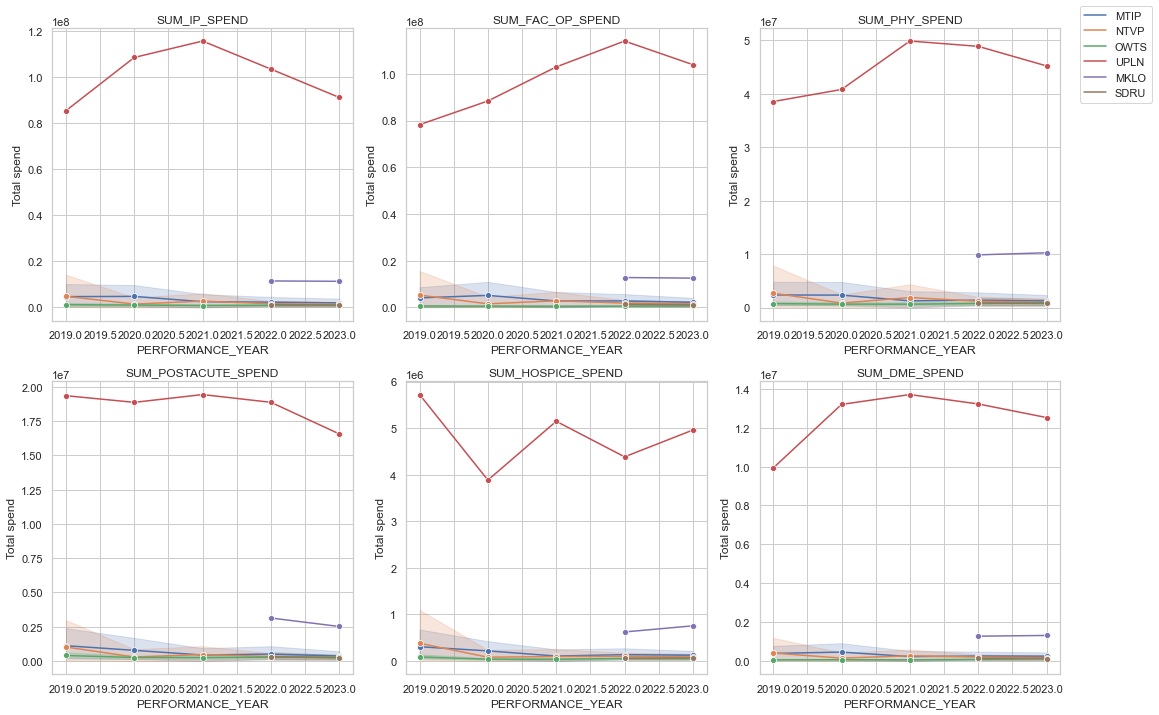

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=False)
legend_labels={}
for index,y_ax in enumerate(y_axis):
    ax = plt.subplot(2,3,index+1)
    sns.lineplot(ax=ax, data=df3,x='PERFORMANCE_YEAR',y=y_ax,hue='QRO',marker='o')
    plt.title(y_ax)
    plt.ylabel('Total spend')
    handles, labels = ax.get_legend_handles_labels()
    legend_labels[y_ax] = (handles, labels)
for ax in fig.axes:
    ax.get_legend().remove()
fig.legend(*legend_labels[y_axis[-1]], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### TIN_Q10-13_Event_Rate


In [24]:
df4.head(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE
0,2019,MTIP,183834,797.1,0.758,307.5,0.139
1,2019,MTIP,834843,688.6,0.696,230.1,0.094
2,2019,MTIP,122406,166.7,1.000,NaN,NaN
3,2019,MTIP,125904,1062.5,0.735,218.8,NaN
4,2019,MTIP,496926,1004.5,0.779,354.0,0.145


In [25]:
df4.columns[3:]

Index(['ED_VISIT_RATE', 'ED_RETURN_72HRS', 'IP_ADMIT_RATE',
       'READMIT_30DAY_RATE'],
      dtype='object')

In [26]:
df4.fillna(0,inplace=True)

In [27]:
metrics = ['ED_VISIT_RATE', 'ED_RETURN_72HRS', 'IP_ADMIT_RATE', 'READMIT_30DAY_RATE']
df4_melted = df4.melt(id_vars=['QRO'], value_vars=metrics, var_name='Metric', value_name='Rate')
df4_melted

,QRO,Metric,Rate
0,MTIP,ED_VISIT_RATE,797.100
1,MTIP,ED_VISIT_RATE,688.600
2,MTIP,ED_VISIT_RATE,166.700
3,MTIP,ED_VISIT_RATE,1062.500
4,MTIP,ED_VISIT_RATE,1004.500
...,...,...,...
1251,SDRU,READMIT_30DAY_RATE,0.000
1252,SDRU,READMIT_30DAY_RATE,0.250
1253,SDRU,READMIT_30DAY_RATE,0.000
1254,SDRU,READMIT_30DAY_RATE,0.250


In [28]:
df4_melted[df4_melted.Metric == 'ED_RETURN_72HRS']

,QRO,Metric,Rate
314,MTIP,ED_RETURN_72HRS,0.758
315,MTIP,ED_RETURN_72HRS,0.696
316,MTIP,ED_RETURN_72HRS,1.000
317,MTIP,ED_RETURN_72HRS,0.735
318,MTIP,ED_RETURN_72HRS,0.779
...,...,...,...
623,SDRU,ED_RETURN_72HRS,0.000
624,SDRU,ED_RETURN_72HRS,0.318
625,SDRU,ED_RETURN_72HRS,0.000
626,SDRU,ED_RETURN_72HRS,0.511


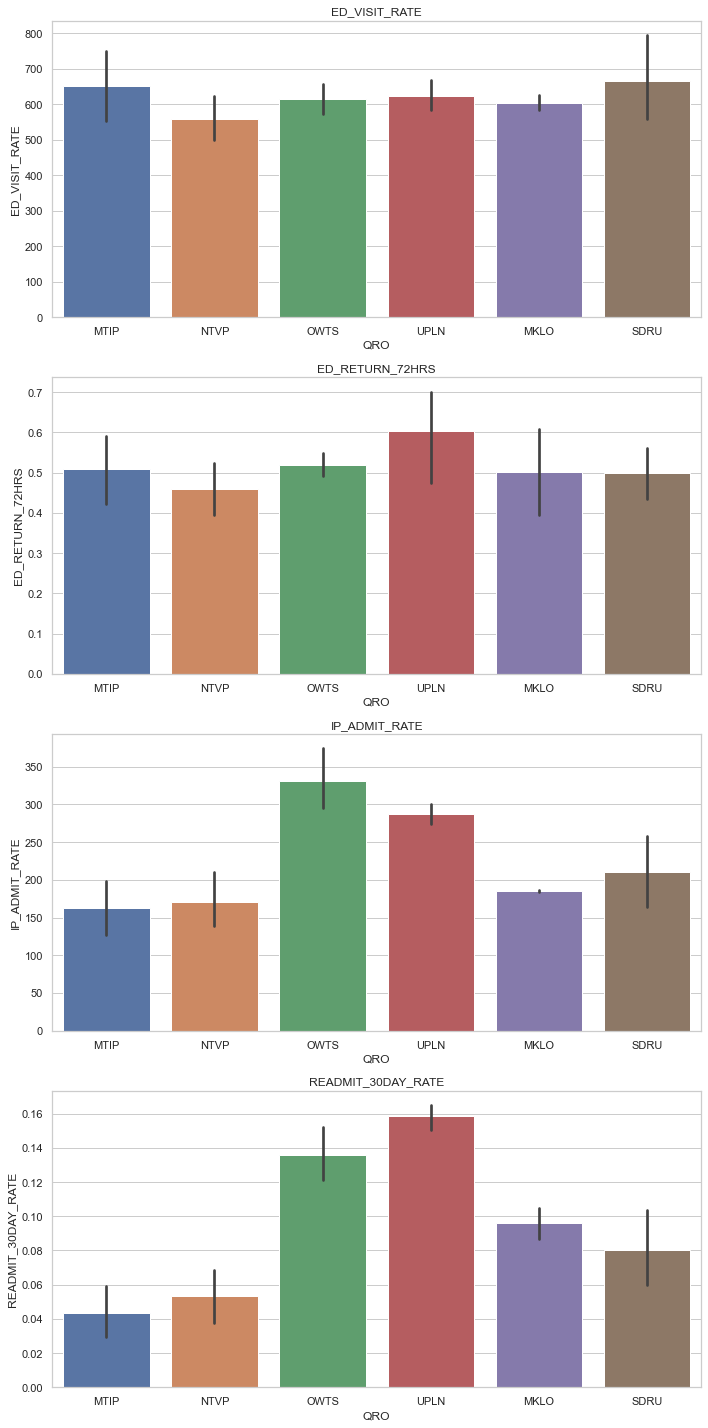

In [29]:
# plt.figure(figsize=(14,8))
# sns.barplot(data=df4_melted,x='Metric',y='Rate',hue='QRO')
# plt.show()
fig,axes = plt.subplots(len(metrics),1,figsize=(10,20))
for index,metric in enumerate(metrics):
    sns.barplot(ax=axes[index],x='QRO', y=metric, data=df4)
    axes[index].set_title(metric)
plt.tight_layout()
plt.show()

#### TIN_VISIT_Q8-14

In [30]:
df5.sample(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,AWV_RATE,SUM_PCP_VISITS,CNT_PCP_VISITS,SUM_SPEC_VISITS,CNT_SPEC_VISITS
281,2023,NTVP,604033,0.243,1841873.83,13328,489046.59,6488
101,2021,OWTS,248237,0.689,96536.44,1069,48968.87,610
235,2022,SDRU,556858,0.000,16870.53,187,6771.96,84
254,2023,MTIP,496926,0.423,1174687.05,9165,430960.68,5898
224,2022,SDRU,556667,0.066,45874.68,754,76323.70,1021


In [31]:
df5.isnull().sum()

PERFORMANCE_YEAR    0
QRO                 0
TIN_CCN             0
AWV_RATE            0
SUM_PCP_VISITS      0
CNT_PCP_VISITS      0
SUM_SPEC_VISITS     0
CNT_SPEC_VISITS     0
dtype: int64

In [32]:
df5['AVG_PCP_VISIT'] = df5['SUM_PCP_VISITS'] / df5['CNT_PCP_VISITS']
df5['AVG_SPEC_VISIT'] = df5['SUM_SPEC_VISITS'] / df5['CNT_SPEC_VISITS']
df5_AVG = df5[['QRO','AVG_PCP_VISIT','AVG_SPEC_VISIT']]
df5_AVG


,QRO,AVG_PCP_VISIT,AVG_SPEC_VISIT
0,MTIP,98.859000,38.346667
1,MTIP,122.300000,NaN
2,MTIP,8.790000,NaN
3,MTIP,NaN,NaN
4,MTIP,103.826808,60.129935
...,...,...,...
347,SDRU,73.203802,72.891298
348,SDRU,80.700000,75.209394
349,SDRU,68.393713,72.628817
350,SDRU,77.962321,80.745161


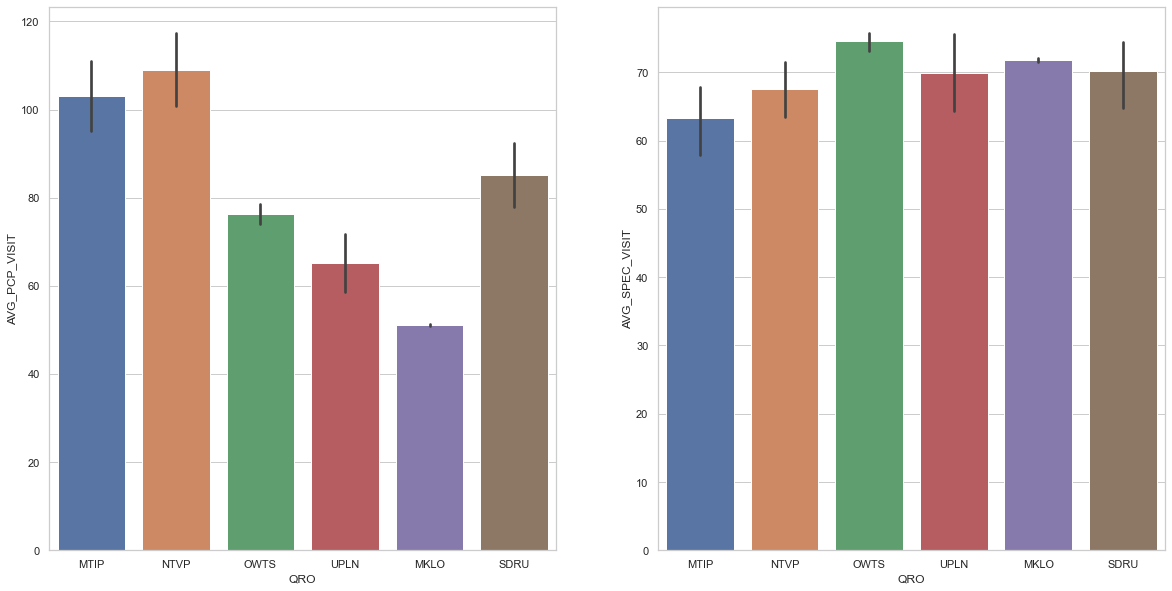

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(data=df5_AVG,x='QRO',y='AVG_PCP_VISIT')
plt.subplot(1,2,2)
sns.barplot(data=df5_AVG,x='QRO',y='AVG_SPEC_VISIT')
plt.show()

## Create composite score


### Normalize the metrics
#### Cost Efficiency (CE)


In [34]:
df2['TOTAL_SPEND_NORMALIZED'] = (df2['TOTAL_SPEND'] - df2['TOTAL_SPEND'].min()) / (df2['TOTAL_SPEND'].max() - df2['TOTAL_SPEND'].min())
df2.head(10)

,PERFORMANCE_YEAR,QRO,TIN_CCN,TOTAL_SPEND,AGED_TOTAL_SPEND,DISABLED_TOTAL_SPEND,ESRD_TOTAL_ESRD,AGED_DUAL_TOTAL_SPEND,TOTAL_SPEND_NORMALIZED
0,2019,MTIP,122406,18332.78,1755.58,16577.20,0.00,0.00,5.891776e-05
1,2019,MTIP,679036,122.30,122.30,0.00,0.00,0.00,3.930469e-07
2,2019,MTIP,344888,8.79,0.00,0.00,8.79,0.00,2.824924e-08
3,2019,MTIP,125904,326079.83,165138.70,61145.21,99795.92,0.00,1.047953e-03
4,2019,MTIP,183834,51693176.93,36549230.25,7356027.20,3118860.85,4668087.62,1.661312e-01
5,2019,MTIP,496926,23839256.13,13611249.27,4249489.28,2781353.80,3197163.78,7.661443e-02
6,2019,MTIP,834843,15403252.31,9968983.63,3492489.05,531538.09,1410241.54,4.950286e-02
7,2019,NTVP,781599,417667.13,224500.66,49167.75,0.00,143998.72,1.342296e-03
8,2019,NTVP,592226,593702.46,298825.48,73632.90,183604.05,37640.03,1.908037e-03
9,2019,NTVP,604033,43165389.11,29258932.13,7510381.24,2142818.04,4253257.70,1.387246e-01


In [35]:
df3['TOTAL_SPEND'] = df3["SUM_IP_SPEND"] + df3["SUM_FAC_OP_SPEND"] + df3["SUM_PHY_SPEND"] + df3["SUM_POSTACUTE_SPEND"] + df3["SUM_HOSPICE_SPEND"] + df3["SUM_DME_SPEND"]
df3['TOTAL_SPEND_NORMALIZED'] = (df3['TOTAL_SPEND'] - df3['TOTAL_SPEND'].min()) / (df3['TOTAL_SPEND'].max() - df3['TOTAL_SPEND'].min())
df3.head(10)

,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND,TOTAL_SPEND,TOTAL_SPEND_NORMALIZED
0,2019,MTIP,183834,19192504.70,16020228.69,9062788.08,4477877.38,1320060.30,1349982.92,51423442.07,1.676181e-01
1,2019,MTIP,834843,5364179.15,4602899.62,3152931.99,1253099.57,433572.46,548635.03,15355317.82,5.005166e-02
2,2019,MTIP,122406,0.00,11329.40,7003.38,0.00,0.00,0.00,18332.78,5.975689e-05
3,2019,MTIP,344888,0.00,8.79,0.00,0.00,0.00,0.00,8.79,2.865158e-08
4,2019,MTIP,125904,48225.71,134299.70,101493.16,12408.65,0.00,25392.39,321819.61,1.048992e-03
5,2019,MTIP,679036,0.00,122.30,0.00,0.00,0.00,0.00,122.30,3.986448e-07
6,2019,MTIP,496926,8349692.58,7973268.19,4120389.79,2062108.87,386510.00,809313.60,23701283.03,7.725588e-02
7,2019,NTVP,604033,14219144.68,15605275.94,7850739.14,2978073.88,1096923.82,1191230.15,42941387.61,1.399703e-01
8,2019,NTVP,592226,204133.09,205026.42,100282.72,42342.66,18145.17,20507.22,590437.28,1.924569e-03
9,2019,NTVP,781599,173285.78,77484.92,82410.87,38663.52,24292.54,20873.07,417010.70,1.359274e-03


#### Visit Rate Effectiveness (VRE)

In [54]:
scaler = StandardScaler()
df4['VISIT_RATE_EFFECTIVENESS'] = 0.75 * (1 - df4['ED_RETURN_72HRS']) + 0.25 * (1 - df4['READMIT_30DAY_RATE'])
df4['EFFECTIVENESS_NORMALIZED'] = (df4['VISIT_RATE_EFFECTIVENESS'] - df4['VISIT_RATE_EFFECTIVENESS'].min()) / (df4['VISIT_RATE_EFFECTIVENESS'].max() - df4['VISIT_RATE_EFFECTIVENESS'].min())
df4


,PERFORMANCE_YEAR,QRO,TIN_CCN,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE,VISIT_RATE_EFFECTIVENESS,EFFECTIVENESS_NORMALIZED
0,2019,MTIP,183834,797.1,0.758,307.5,0.139,0.39675,0.257538
1,2019,MTIP,834843,688.6,0.696,230.1,0.094,0.45450,0.328615
2,2019,MTIP,122406,166.7,1.000,0.0,0.000,0.25000,0.076923
3,2019,MTIP,125904,1062.5,0.735,218.8,0.000,0.44875,0.321538
4,2019,MTIP,496926,1004.5,0.779,354.0,0.145,0.37950,0.236308
...,...,...,...,...,...,...,...,...,...
309,2023,SDRU,680049,142.9,0.000,47.6,0.000,1.00000,1.000000
310,2023,SDRU,857343,440.0,0.318,160.0,0.250,0.69900,0.629538
311,2023,SDRU,614138,142.9,0.000,0.0,0.000,1.00000,1.000000
312,2023,SDRU,676890,552.9,0.511,235.3,0.250,0.55425,0.451385


In [55]:
print(scaler.fit_transform(df4[['VISIT_RATE_EFFECTIVENESS']]))

[[-1.1406662 ]
 [-0.81537022]
 [-1.96728414]
 [-0.847759  ]
 [-1.23783254]
 [-1.06180657]
 [-1.10123639]
 [-0.7027136 ]
 [-0.97027307]
 [-0.66469199]
 [-0.60273085]
 [-0.86043286]
 [-0.62526217]
 [-0.76889936]
 [-0.68581511]
 [-1.02378496]
 [-0.08028578]
 [-0.62103755]
 [-0.79565531]
 [-0.65483454]
 [-0.29996619]
 [-0.94351712]
 [-0.5759749 ]
 [-0.97308948]
 [-0.82100305]
 [-0.06057087]
 [-1.96728414]
 [-0.44641979]
 [-0.55344358]
 [-0.79143069]
 [-0.86888211]
 [-0.40135714]
 [-1.26036386]
 [-1.02378496]
 [-1.25754745]
 [-0.56048462]
 [-1.00688647]
 [ 1.20118326]
 [-1.96728414]
 [-1.11954309]
 [-1.43216521]
 [-1.96728414]
 [-0.56048462]
 [-1.06180657]
 [ 2.25733906]
 [-1.02941779]
 [-0.01832464]
 [-1.05476553]
 [ 0.19009011]
 [-0.07606116]
 [ 1.29834959]
 [-1.07729686]
 [-0.56048462]
 [ 0.16333416]
 [-0.44078696]
 [-0.59850623]
 [-0.58301594]
 [-0.26053637]
 [-0.45909366]
 [ 0.00279848]
 [-0.88155598]
 [-0.59005698]
 [-1.47863606]
 [-0.46895111]
 [-1.49694276]
 [-0.63793604]
 [-0.56048

#### Patient Complexity & Outcomes

In [37]:
df1['BENE_CNT'] = df1['BENE_CNT'].replace('<11',5.5).astype(float)

# One-hot encode 'ENROLLMENT_TYPE'
encoder = OneHotEncoder(sparse=False)
encoded_types = encoder.fit_transform(df1[['ENROLLMENT_TYPE']])
encoded_type_df = pd.DataFrame(encoded_types,columns=encoder.get_feature_names_out())

# Normalize 'BENE_CNT' and 'AVR_RISK_SCORE'
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df1[['BENE_CNT','AVR_RISK_SCORE']])
normalized_df = pd.DataFrame(normalized_values,columns=['BENE_CNT_NORM','AVR_RISK_SCORE_NORM'])

normalized_matrix = pd.concat([df1[['PERFORMANCE_YEAR','QRO','TIN_CCN']],encoded_type_df,normalized_df],axis=1)
normalized_matrix



/Users/wzyy/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE_Aged,ENROLLMENT_TYPE_Aged-Dual,ENROLLMENT_TYPE_Disabled,ENROLLMENT_TYPE_ESRD,ENROLLMENT_TYPE_Unknown,BENE_CNT_NORM,AVR_RISK_SCORE_NORM
0,2019,OWTS,230982,0.0,0.0,0.0,1.0,0.0,0.0,1.000000
1,2023,SDRU,636998,0.0,0.0,1.0,0.0,0.0,0.0,0.856503
2,2023,OWTS,254468,0.0,1.0,0.0,0.0,0.0,0.0,0.832941
3,2022,OWTS,659770,0.0,0.0,0.0,1.0,0.0,0.0,0.763195
4,2020,NTVP,592226,0.0,0.0,0.0,1.0,0.0,0.0,0.739868
...,...,...,...,...,...,...,...,...,...,...
1130,2022,OWTS,355426,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
1131,2022,OWTS,253824,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1132,2023,OWTS,566158,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
1133,2022,SDRU,636998,0.0,1.0,0.0,0.0,0.0,0.0,0.000000


In [38]:
df_com_score = df3.merge(df4,on=['TIN_CCN','PERFORMANCE_YEAR'])[['PERFORMANCE_YEAR','TIN_CCN','TOTAL_SPEND_NORMALIZED','EFFECTIVENESS_NORMALIZED']]
# df_com_score['Composite_Score'] = 0.5* df_com_score['TOTAL_SPEND_NORMALIZED'] + 0.5 * df_com_score['EFFECTIVENESS_NORMALIZED']
df_com_score = normalized_matrix.merge(df_com_score,on=['TIN_CCN','PERFORMANCE_YEAR'])
df_com_score

,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE_Aged,ENROLLMENT_TYPE_Aged-Dual,ENROLLMENT_TYPE_Disabled,ENROLLMENT_TYPE_ESRD,ENROLLMENT_TYPE_Unknown,BENE_CNT_NORM,AVR_RISK_SCORE_NORM,TOTAL_SPEND_NORMALIZED,EFFECTIVENESS_NORMALIZED
0,2019,OWTS,230982,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.012368,0.318769
1,2019,OWTS,230982,0.0,1.0,0.0,0.0,0.0,0.002441,0.278040,0.012368,0.318769
2,2019,OWTS,230982,0.0,0.0,1.0,0.0,0.0,0.001029,0.251178,0.012368,0.318769
3,2019,OWTS,230982,1.0,0.0,0.0,0.0,0.0,0.009557,0.243402,0.012368,0.318769
4,2023,SDRU,636998,0.0,0.0,1.0,0.0,0.0,0.000000,0.856503,0.000236,0.604000
...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,SDRU,812423,1.0,0.0,0.0,0.0,0.0,0.000000,0.068332,0.000012,1.000000
1074,2022,SDRU,812423,0.0,0.0,1.0,0.0,0.0,0.000000,0.060556,0.000012,1.000000
1075,2023,NTVP,602055,1.0,0.0,0.0,0.0,0.0,0.000000,0.064562,0.000021,1.000000
1076,2023,NTVP,455724,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000116,1.000000


In [39]:
from sklearn.decomposition import PCA

features = ['ENROLLMENT_TYPE_Aged', 'ENROLLMENT_TYPE_Aged-Dual', 'ENROLLMENT_TYPE_Disabled', 
            'ENROLLMENT_TYPE_ESRD', 'ENROLLMENT_TYPE_Unknown', 'BENE_CNT_NORM', 
            'AVR_RISK_SCORE_NORM', 'TOTAL_SPEND_NORMALIZED', 'EFFECTIVENESS_NORMALIZED']

x = df_com_score.loc[:,features].values
pca = PCA(n_components=2) # for simplicity, we're reducing data to 2 dimensions
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf


,principal component 1,principal component 2
0,-0.021037,0.093490
1,-0.090961,0.833580
2,-0.671577,-0.454479
3,0.734935,-0.311263
4,-0.664249,-0.452512
...,...,...
1073,0.742863,-0.323702
1074,-0.663526,-0.467204
1075,0.742841,-0.323742
1076,0.742468,-0.324432


In [40]:
# df_com_score[df_com_score.TIN_CCN==855505]

## Bipartite network

In [41]:
spend_bins = pd.qcut(df_com_score['TOTAL_SPEND_NORMALIZED'],3,labels=['Low Spend','Medium Spend','High Spend'])
effectiveness_bins = pd.cut(df_com_score['EFFECTIVENESS_NORMALIZED'],3,labels=['Low Effectiveness','Medium Effectiveness','High Effectiveness'])
bi_network_df = df_com_score[['TIN_CCN']]
bi_network_df['Spend Category'] = spend_bins
bi_network_df['Effectiveness Category'] = effectiveness_bins
bi_network_df

<ipython-input-41-aef0f0990255>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bi_network_df['Spend Category'] = spend_bins
<ipython-input-41-aef0f0990255>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bi_network_df['Effectiveness Category'] = effectiveness_bins


,TIN_CCN,Spend Category,Effectiveness Category
0,230982,High Spend,Low Effectiveness
1,230982,High Spend,Low Effectiveness
2,230982,High Spend,Low Effectiveness
3,230982,High Spend,Low Effectiveness
4,636998,Low Spend,Medium Effectiveness
...,...,...,...
1073,812423,Low Spend,High Effectiveness
1074,812423,Low Spend,High Effectiveness
1075,602055,Low Spend,High Effectiveness
1076,455724,Low Spend,High Effectiveness


In [42]:
# bi_network_df[(bi_network_df['Spend Category']=='High Spend') & (bi_network_df['Effectiveness Category']=='High Effectiveness')]

In [43]:
B = nx.Graph()
spend_categories = bi_network_df['Spend Category'].unique()
effectiveness_categories = bi_network_df['Effectiveness Category'].unique()

B.add_nodes_from(effectiveness_categories,bipartite=1)
B.add_nodes_from(spend_categories,bipartite=0)

for _,row in bi_network_df.iterrows():
    B.add_edge(row['TIN_CCN'],row['Spend Category'])
    B.add_edge(row['TIN_CCN'],row['Effectiveness Category'])
    
# pos = nx.spring_layout(B)
# nx.draw(B,pos,with_labels=True,node_size=50,font_size=9)
# plt.show()

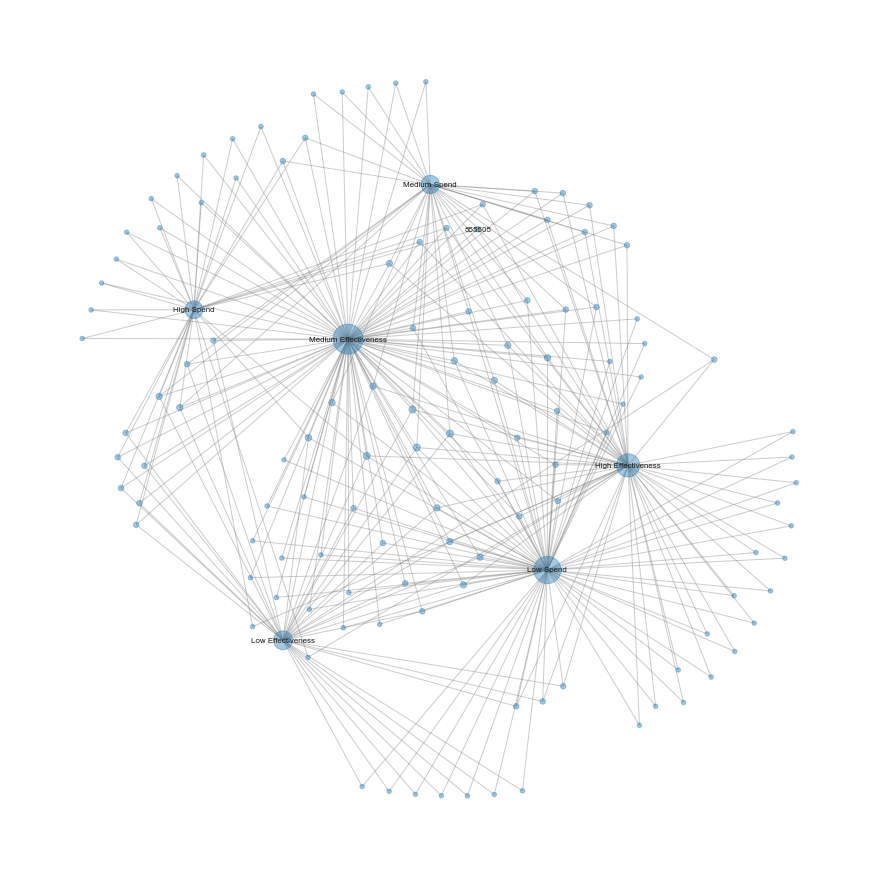

In [44]:
# Calculate node degrees for size
degrees = dict(nx.degree(B))
sizes = [degrees[node] * 10 for node in B.nodes()]

# Choose a layout that spreads nodes more evenly
pos = nx.kamada_kawai_layout(B)

# Draw the network
plt.figure(figsize=(12, 12))
nx.draw(B, pos, node_size=sizes, edge_color='gray', alpha=0.4, with_labels=False)

# Draw labels for nodes with degree larger than a threshold
labels = {node: node for node in B.nodes() if degrees[node] > 10}
labels[855505] = '855505'
nx.draw_networkx_labels(B, pos, labels, font_size=8)

# Show plot
plt.show()

### Calculate composite score

In [45]:
weights = {
    'ENROLLMENT_TYPE_Aged': 0.05,
    'ENROLLMENT_TYPE_Aged-Dual': 0.07,
    'ENROLLMENT_TYPE_Disabled': 0.05,
    'ENROLLMENT_TYPE_ESRD': 0.08,
    'ENROLLMENT_TYPE_Unknown': 0.02,
    'BENE_CNT_NORM': 0.05,
    'AVR_RISK_SCORE_NORM': 0.15,
    'TOTAL_SPEND_NORMALIZED': 0.25,  # Increased weight
    'EFFECTIVENESS_NORMALIZED': 0.28,  # Increased weight
}
df_com_score['Composite_Score'] = sum(df_com_score[col] * weight for col, weight in weights.items())
df_com_score

,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE_Aged,ENROLLMENT_TYPE_Aged-Dual,ENROLLMENT_TYPE_Disabled,ENROLLMENT_TYPE_ESRD,ENROLLMENT_TYPE_Unknown,BENE_CNT_NORM,AVR_RISK_SCORE_NORM,TOTAL_SPEND_NORMALIZED,EFFECTIVENESS_NORMALIZED,Composite_Score
0,2019,OWTS,230982,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.012368,0.318769,0.322347
1,2019,OWTS,230982,0.0,1.0,0.0,0.0,0.0,0.002441,0.278040,0.012368,0.318769,0.204175
2,2019,OWTS,230982,0.0,0.0,1.0,0.0,0.0,0.001029,0.251178,0.012368,0.318769,0.180075
3,2019,OWTS,230982,1.0,0.0,0.0,0.0,0.0,0.009557,0.243402,0.012368,0.318769,0.179335
4,2023,SDRU,636998,0.0,0.0,1.0,0.0,0.0,0.000000,0.856503,0.000236,0.604000,0.347654
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,SDRU,812423,1.0,0.0,0.0,0.0,0.0,0.000000,0.068332,0.000012,1.000000,0.340253
1074,2022,SDRU,812423,0.0,0.0,1.0,0.0,0.0,0.000000,0.060556,0.000012,1.000000,0.339087
1075,2023,NTVP,602055,1.0,0.0,0.0,0.0,0.0,0.000000,0.064562,0.000021,1.000000,0.339689
1076,2023,NTVP,455724,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000116,1.000000,0.330029


### Rank TIN_CCN

In [46]:
df_com_score.sort_values(['Composite_Score'],ascending=False)

,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE_Aged,ENROLLMENT_TYPE_Aged-Dual,ENROLLMENT_TYPE_Disabled,ENROLLMENT_TYPE_ESRD,ENROLLMENT_TYPE_Unknown,BENE_CNT_NORM,AVR_RISK_SCORE_NORM,TOTAL_SPEND_NORMALIZED,EFFECTIVENESS_NORMALIZED,Composite_Score
140,2023,UPLN,430950,0.0,0.0,0.0,1.0,0.0,0.012850,0.399387,0.894247,0.635385,0.542020
142,2023,UPLN,430950,1.0,0.0,0.0,0.0,0.0,1.000000,0.240811,0.894247,0.635385,0.537591
143,2023,UPLN,430950,0.0,1.0,0.0,0.0,0.0,0.056430,0.234920,0.894247,0.635385,0.509529
172,2022,UPLN,430950,0.0,0.0,0.0,1.0,0.0,0.015026,0.397974,0.987175,0.412308,0.502687
141,2023,UPLN,430950,0.0,0.0,1.0,0.0,0.0,0.124768,0.297597,0.894247,0.635385,0.502347
...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,2021,MTIP,125904,1.0,0.0,0.0,0.0,0.0,0.000000,0.065740,0.000151,0.076923,0.081437
1043,2021,MTIP,166870,0.0,0.0,1.0,0.0,0.0,0.000000,0.039821,0.000058,0.076923,0.077526
742,2022,SDRU,636998,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000126,0.000000,0.070032
741,2022,SDRU,636998,1.0,0.0,0.0,0.0,0.0,0.000000,0.082705,0.000126,0.000000,0.062437


Higher scores indicate better overall performance considering both cost efficiency and visit rate effectiveness.

## Model Evaluation


In [47]:
X = df_com_score.drop(['PERFORMANCE_YEAR', 'QRO', 'TIN_CCN', 'Composite_Score'],axis=1)
y = df_com_score['Composite_Score']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train_scaled,y_train)

y_pred = model.predict(X_test_scaled)


In [48]:
mse = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

Mean Squared Error: 7.999682725809484e-05
R-squared: 0.9818839753618205


#### Residual Analysis

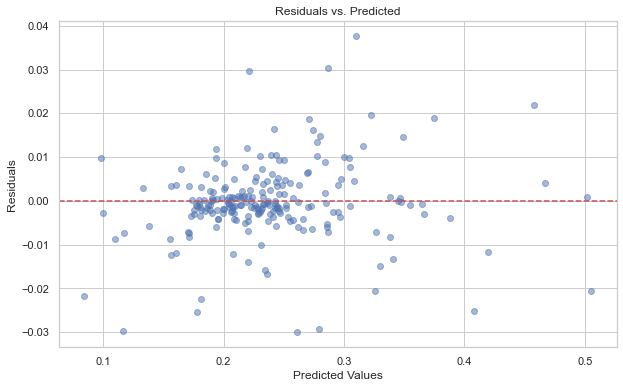

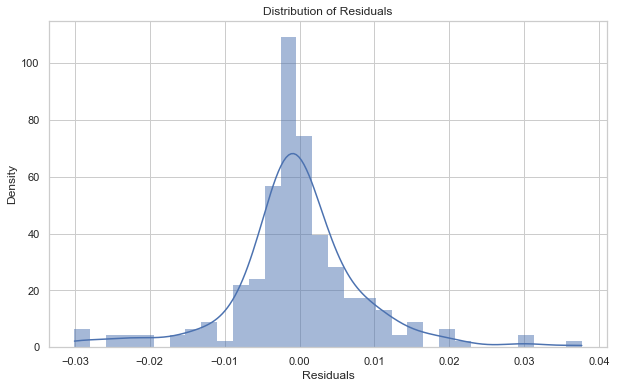

In [49]:
residuals = y_test - y_pred
# Basic Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Checking for normality of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, stat="density", linewidth=0)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

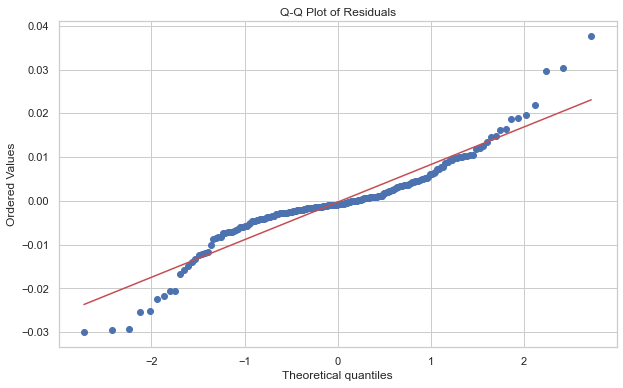

In [50]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

#### Conclusions
* The model seems to be performing well for the majority of the data, as indicated by the residuals' distribution being centered around zero and the R-squared value previously mentioned (0.98188).
* The slight right skew in the histogram and the heavier tails observed in the Q-Q plot suggest the presence of outliers or extreme values that the model is not predicting as accurately.
* The skew and outliers could also suggest that the model might be improved by transforming the target variable (such as using a logarithmic transformation if the target is strictly positive) or by investigating the reasons for these extreme values. They might be due to unusual circumstances not captured by the model, data entry errors, or other anomalies.